# Description 

This notebook demonstrates how to use the DriftStream API in CapyMOA. We show how to use RandomTreeGenerator to generate a synthetic stream. Lastly, we use recurrent concept drift API to generate recurrent concepts. These synthetic streams are evaluated using 2 ensemble learners: Online Bagging with ADWIN and Hoeffding Adaptive Tree in both River and CapyMOA.

# Imports

In [4]:
# CapyMoa
from capymoa.evaluation import prequential_evaluation
from capymoa.classifier import HoeffdingAdaptiveTree
from capymoa.classifier import OnlineAdwinBagging
from capymoa.stream.drift import DriftStream, AbruptDrift, GradualDrift, RecurrentConceptDriftStream
from capymoa.stream.generator import SEA, RandomTreeGenerator
from capymoa.stream.generator import RandomTreeGenerator
from capymoa.evaluation.visualization import plot_windowed_results

# River
from river.tree import HoeffdingAdaptiveTreeClassifier, HoeffdingTreeClassifier
from river.ensemble import ADWINBaggingClassifier
from river.evaluate import progressive_val_score
from river.metrics import Accuracy

# Miscellaneous for tracking
import time, tracemalloc, psutil
import matplotlib.pyplot as plt

# Utils

In [5]:
# Generator to yield (x_dict, y) in river format
def capymoa_to_river_stream(stream):
    feature_names = stream.get_schema().get_numeric_attributes()
    for instance in stream:
        x_dict = dict(zip(feature_names, instance.x))
        y = instance.y_index 
        yield x_dict, y

# Start measurements
def start_measurements():
    tracemalloc.start()
    start_time = time.time()
    cpu_start = psutil.cpu_percent(interval=None)
    return start_time, cpu_start

def end_measurements():
    end_time = time.time()
    cpu_end = psutil.cpu_percent(interval=None)
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return end_time, cpu_end, current, peak

# Function to plot the results
def plot_results(results, plot_title):
    # Print results for each learner
    for name, scores in results.items():
        rmse_values = [score['RMSE'].get() for score in scores]
        steps = [score['Step'] for score in scores]  
        plt.plot(steps, rmse_values, label=name)

    plt.xlabel("Instance")
    plt.ylabel("Metric")
    plt.title(plot_title)
    plt.legend()
    plt.grid(True)
    plt.show()

# CapyMOA


--- Performance Summary ---
Total Time: 0.39 seconds
CPU Usage: 50.6%
Peak Memory Usage: 0.04 MB


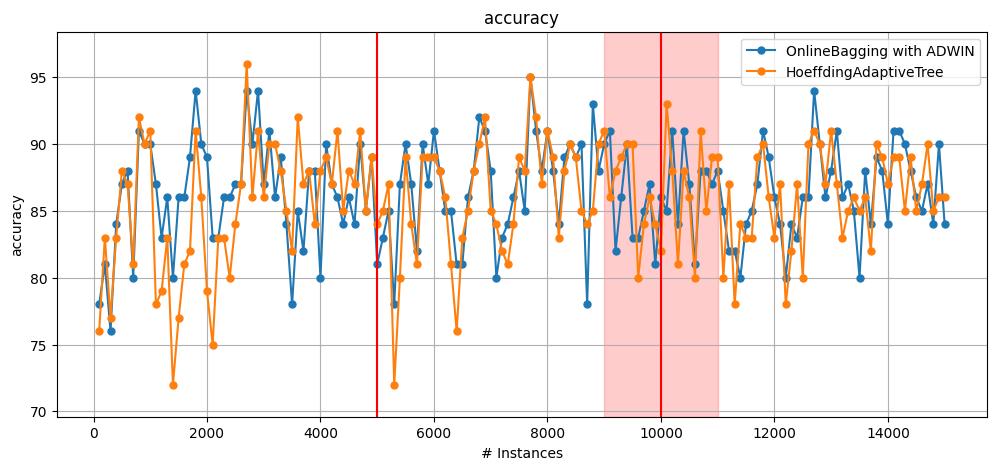

In [13]:
stream_sea2drift = DriftStream(
    stream=[
        SEA(function=1),
        AbruptDrift(position=5000),
        SEA(function=3),
        GradualDrift(position=10000, width=2000),
        SEA(function=1),
    ]
)

# Define the learners + an alias (dictionary key)
learners = {
    "OB": OnlineAdwinBagging(schema=stream_sea2drift.get_schema(), ensemble_size=10),
    "HAT": HoeffdingAdaptiveTree(schema=stream_sea2drift.get_schema()),
}

start_time, cpu_start = start_measurements()

results = {name: [] for name in learners.keys()}
for name, learner in learners.items():
    results_sea2drift = prequential_evaluation(stream=stream_sea2drift, learner=learner, window_size=100, max_instances=15000)
    results[name] = results_sea2drift

end_time, cpu_end, current, peak = end_measurements()

print(f"\n--- Performance Summary ---")
print(f"Total Time: {end_time - start_time:.2f} seconds")
print(f"CPU Usage: {cpu_end}%")
print(f"Peak Memory Usage: {peak / 10**6:.2f} MB")

plot_windowed_results(results["OB"], results["HAT"], metric="accuracy")

We generate a stream with recurrent concepts.

In [5]:
concept1 = RandomTreeGenerator(tree_random_seed=1, instance_random_seed=1)
concept2 = RandomTreeGenerator(tree_random_seed=2, instance_random_seed=1)
concept3 = RandomTreeGenerator(tree_random_seed=3, instance_random_seed=1)

window_size = 1000
concept_length = 2000
concept_list = [concept1, concept2, concept3]
concept_name_list = ["concept1", "concept2", "concept3"]
max_recurrences_per_concept = 2
max_instances = concept_length * len(concept_list) * max_recurrences_per_concept

stream_with_recurrent_concepts = RecurrentConceptDriftStream(
    concept_list=concept_list,
    max_recurrences_per_concept=max_recurrences_per_concept,
    transition_type_template=AbruptDrift(position=concept_length),
    concept_name_list=concept_name_list,
)


--- Performance Summary ---
Total Time: 0.51 seconds
CPU Usage: 37.0%
Peak Memory Usage: 0.02 MB


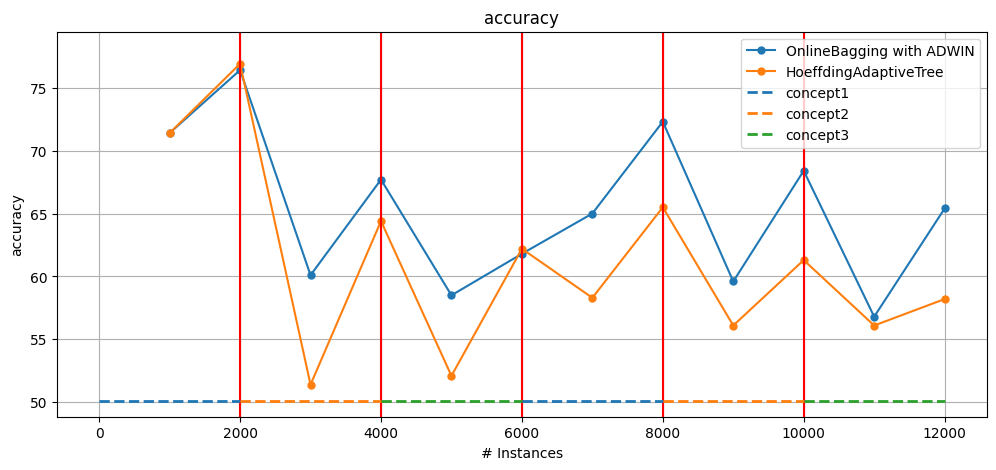

In [ ]:
# Define the learners + an alias (dictionary key)
learners = {
    "OB": OnlineAdwinBagging(schema=stream_sea2drift.get_schema(), ensemble_size=10),
    "HAT": HoeffdingAdaptiveTree(schema=stream_sea2drift.get_schema()),
}

start_time, cpu_start = start_measurements()

results = {name: [] for name in learners.keys()}
for name, learner in learners.items():
    results_stream_with_drifts = prequential_evaluation(
        stream=stream_with_recurrent_concepts,
        learner=learner,
        window_size=window_size,
        max_instances=max_instances,
    )
    results[name] = results_stream_with_drifts

end_time, cpu_end, current, peak = end_measurements()

print(f"\n--- Performance Summary ---")
print(f"Total Time: {end_time - start_time:.2f} seconds")
print(f"CPU Usage: {cpu_end}%")
print(f"Peak Memory Usage: {peak / 10**6:.2f} MB")

plot_windowed_results(results["OB"], results["HAT"], metric="accuracy")

# River

For River we demonstrate a similar functionality only using recurrent concept drifts. Since River takes more time to train the concept length has been reduced.

In [ ]:
concept1 = RandomTreeGenerator(tree_random_seed=1, instance_random_seed=1)
concept2 = RandomTreeGenerator(tree_random_seed=2, instance_random_seed=1)
concept3 = RandomTreeGenerator(tree_random_seed=3, instance_random_seed=1)

window_size = 100 # 10 times less than original CapyMOA 
concept_length = 200 # 10 times less than original CapyMOA 
concept_list = [concept1, concept2, concept3]
concept_name_list = ["concept1", "concept2", "concept3"]
max_recurrences_per_concept = 2
max_instances = concept_length * len(concept_list) * max_recurrences_per_concept

stream_with_recurrent_concepts = RecurrentConceptDriftStream(
    concept_list=concept_list,
    max_recurrences_per_concept=max_recurrences_per_concept,
    transition_type_template=AbruptDrift(position=concept_length),
    concept_name_list=concept_name_list,
)

In [ ]:
base_learner = HoeffdingTreeClassifier()

# Define the learners
learners = {
    "HAT": HoeffdingAdaptiveTreeClassifier(),
    "OB": ADWINBaggingClassifier(model=base_learner, n_models=10),
}

# Create a prequential evaluation loop for multiple learners
results = { name: [] for name in learners }

start_time, cpu_start = start_measurements()

for name, model in learners.items():
    # Convert CapyMoa stream to River
    stream = capymoa_to_river_stream(stream_with_recurrent_concepts)
    
    metric = Accuracy()
    result = progressive_val_score(dataset=stream, model=model, metric=metric)
    results[name] = result

end_time, cpu_end, current, peak = end_measurements()

print(f"\n--- Performance Summary ---")
print(f"Total Time: {(end_time - start_time) / 60 :.2f} minutes")
print(f"CPU Usage: {cpu_end}%")
print(f"Peak Memory Usage: {peak / 10**6:.2f} MB")